In [1]:
import torch
import math
from tqdm import trange

def heuristics_step_size(stepsize, mean_acceptance, target_acceptance=0.75, factor=1.03, tol=0.01):
    """Heuristic for adaptative step size"""
    if mean_acceptance - target_acceptance > tol:
        return stepsize * factor
    if target_acceptance - mean_acceptance > tol:
        return stepsize / factor
    return min(stepsize, 1.0)


def heuristics_step_size_vectorized(stepsize, mean_acceptance, target_acceptance=0.75, factor=1.03, tol=0.01):
    """Heuristic for adaptative step size in a vectorized fashion"""
    stepsize = torch.minimum(
        torch.where((mean_acceptance - target_acceptance > tol).view((-1, *(1,)
                    * (len(stepsize.shape) - 1))), stepsize * factor, stepsize),
        torch.ones_like(stepsize)
    )
    stepsize = torch.minimum(
        torch.where((target_acceptance - mean_acceptance > tol).view((-1, *(1,)
                    * (len(stepsize.shape) - 1))), stepsize / factor, stepsize),
        torch.ones_like(stepsize)
    )
    return stepsize


def sample_multivariate_normal_diag(batch_size, mean, variance):
    """Sample according to multivariate normal with diagonal matrix"""
    z = torch.randn((batch_size, *mean.shape[1:]), device=mean.device)
    if isinstance(variance, torch.Tensor):
        return torch.sqrt(variance) * z + mean
    else:
        return math.sqrt(variance) * z + mean


def log_prob_multivariate_normal_diag(samples, mean, variance, sum_indexes):
    """Evaluate the log density of multivariate normal with diagonal matrix

    WARNING: Single sample along a batch size

    The multiplicative factor
            - 0.5 * dim * torch.log(2.0 * torch.pi * variance)
    was removed.
    """
    ret = -0.5 * torch.sum(torch.square(samples - mean), dim=sum_indexes)
    if isinstance(variance, torch.Tensor) and len(variance.shape) > 0:
        ret /= variance.flatten()
    else:
        ret /= variance
    return ret

def ula_mcmc(x0, step_size, score, n_steps, n_warmup_steps=0, return_intermediates=False,
             return_intermediates_gradients=False):
    """Perform multiple steps of the ULA algorithm

        X_{k+1} = X_k + steps_size * score(X_k) + sqrt(2 * step_size) * Z_k

    Args:
        x0 (torch.Tensor of shape (batch_size, *data_shape)): Initial sample
        step_size (float): Step size for Langevin
        score (function): Gradient of the log-likelihood of the target distribution
        n_steps (int): Number of steps of the algorithm
        n_warmup_steps (int): Number of warmup steps (default is 0)
        return_intermediates (bool): Whether to return intermediates states
        return_intermediates_gradients (bool): Whether to return intermediates gradients
            (only is return_intermediates is True)

    Returns:
        x (torch.Tensor of shape (batch_size, *data_shape)): Final sample of the Langevin chain
    """

    x = x0
    if return_intermediates:
        xs = torch.empty((n_steps, *x.shape), device=x.device)
        if return_intermediates_gradients:
            grad_xs = torch.empty_like(xs)
    for i in range(n_warmup_steps+n_steps):
        grad_x = score(x)
        x += step_size * grad_x + torch.sqrt(2. * step_size) * torch.randn_like(x)
        if return_intermediates and (i >= n_warmup_steps):
            xs[i - n_warmup_steps] = x.clone()
            if return_intermediates_gradients and i >= 1:
                grad_xs[i - 1 - n_warmup_steps] = grad_x.clone()
    if return_intermediates:
        if return_intermediates_gradients:
            grad_xs[-1] = score(x).clone()
            return xs, grad_xs
        else:
            return xs
    else:
        return x

def mala_mcmc(
        x0,
        step_size,
        log_prob_and_grad,
        n_steps,
        n_warmup_steps=0,
        per_chain_step_size=True,
        return_intermediates=False,
        return_intermediates_gradients=False,
        target_acceptance=0.75):
    """Perform multiple steps of the MALA algorithm

        X_{k+1} = X_k + steps_size * score(X_k) + sqrt(2 * step_size) * Z_k

    Args:
        x0 (torch.Tensor of shape (batch_size, *data_shape)): Initial sample
        step_size (float): Step size for Langevin
        score (function): Gradient of the log-likelihood of the target distribution
        n_steps (int): Number of steps of the algorithm
        n_warmup_steps (int): Number of warmup steps (default is 0)
        per_chain_step_size (bool): Use a per chain step size (default is True)
        return_intermediates (bool): Whether to return intermediates steps
        target_acceptance (float): Default is 0.75
        return_intermediates_gradients (bool): Whether to return intermediates gradients
            (only is return_intermediates is True)

    Returns:
        x (torch.Tensor of shape (batch_size, *data_shape)): Final sample of the Langevin chain
    """

    sum_indexes = (1,) * (len(x0.shape) - 1)
    x = x0
    log_prob_x, grad_x = log_prob_and_grad(x)
    if return_intermediates:
        xs = torch.empty((n_steps, *x.shape), device=x.device)
        if return_intermediates_gradients:
            grad_xs = torch.empty_like(xs)
    # Reshape the step size if it hasn't been done yet
    if per_chain_step_size and not (isinstance(step_size, torch.Tensor) and len(step_size.shape) > 0):
        step_size = step_size * torch.ones((x.shape[0], *(1,) * (len(x.shape) - 1)), device=x.device)
    for i in range(n_steps+n_warmup_steps):
        # Sample the proposal
        x_prop = sample_multivariate_normal_diag(
            batch_size=x.shape[0],
            mean=x + step_size * grad_x,
            variance=2.0 * step_size
        )
        # Compute log-densities at the proposal
        log_prob_x_prop, grad_x_prop = log_prob_and_grad(x_prop)
        # Compute the MH ratio
        with torch.no_grad():
            joint_prop = log_prob_x_prop - \
                log_prob_multivariate_normal_diag(
                    x_prop,
                    mean=x + step_size * grad_x,
                    variance=2.0 * step_size,
                    sum_indexes=sum_indexes)
            joint_orig = log_prob_x - log_prob_multivariate_normal_diag(x,
                                                                        mean=x_prop + step_size * grad_x_prop,
                                                                        variance=2.0 * step_size,
                                                                        sum_indexes=sum_indexes)
        # Acceptance step
        log_acc = joint_prop - joint_orig
        mask = torch.log(torch.rand_like(log_prob_x_prop, device=x.device)) < log_acc
        x.data[mask] = x_prop[mask]
        log_prob_x.data[mask] = log_prob_x_prop[mask]
        grad_x.data[mask] = grad_x_prop[mask]
        # Update the step size
        if per_chain_step_size:
            step_size = heuristics_step_size_vectorized(step_size,
                                                        torch.minimum(torch.ones_like(log_acc), torch.exp(log_acc)), target_acceptance=target_acceptance)
        else:
            step_size = heuristics_step_size(step_size,
                                             torch.minimum(torch.ones_like(log_acc), torch.exp(log_acc)).mean(), target_acceptance=target_acceptance)
        # Save the sample
        if return_intermediates and (i >= n_warmup_steps):
            xs[i-n_warmup_steps] = x.clone()
            if return_intermediates_gradients:
                grad_xs[i-n_warmup_steps] = grad_x.clone()
    if return_intermediates:
        if return_intermediates_gradients:
            return xs, grad_xs, step_size
        else:
            return xs, step_size
    else:
        return x, step_size



def posterior_log_prob_and_grad(t, y, x, T, target_log_prob_and_grad):
    """Compute the posterior distribution of RDMC and its grading

        q_t(y|x) = pi(x) N(exp(T-t)*x, [(1 - exp(-2*(T-t))) / exp(-2*(T-t))] I)

    Args:
        t (torch.Tensor): Current time
        y (torch.Tensor of shape (batch_size, dim)): Evaluation point
        x (torch.Tensor of shape (batch_size, dim)): Conditioning point
        T (torch.Tensor): Limit time
        target_log_prob_and_grad (function): Log-likelihood of the target and its gradient

    Returns:
        log_prob (torch.Tensor of shape (batch_size,)): Log-likelihood of the posterior
        grad (torch.Tensor of shape (batch_size, dim)): Score of the posterior
    """

    # Evaluate the target
    target_log_prob, target_grad = target_log_prob_and_grad(x)
    # Compute the log_prob
    log_prob = target_log_prob
    log_prob -= 0.5 * torch.sum(torch.square(x - torch.exp(-(T - t)) * y), dim=-1) / (1. - torch.exp(-2. * (T - t)))
    # Compute the gradient
    grad = target_grad
    grad += torch.exp(-t) * (torch.exp(-t) * y - x) / (1. - torch.exp(-2. * t))
    # Return everything
    return log_prob, grad


def posterior_importance_sampling(n_chains, t, x, T, target_log_prob, n_mc_samples=128):
    """Sample the importance distribution associated with the posterior of RDMC

    Args:
        n_chains (int): Number of samples to output per batch_size
        t (torch.Tensor): Current time
        x (torch.Tensor for shape (batch_size, dim)): Conditioning point
        T (torch.Tensor): Limit time
        target_log_prob (function): Target log-likelihood
        n_mc_samples (int): Number of particles (default is 128)

    Returns:
        samples (torch.Tensor for shape (n_chains * batch_size, dim)): Approximate samples from the posterior
    """

    # Compute the variance and the mean
    variance = (1. - torch.exp(-2. * (T - t))) / torch.exp(-2. * (T - t))
    mean = torch.exp((T - t)) * x
    # Generate particles
    z = torch.sqrt(variance) * torch.randn((n_mc_samples, *x.shape), device=x.device)
    z += mean.unsqueeze(0)
    # Compute the importane weights
    log_weight = target_log_prob(z.view((-1, *x.shape[1:]))).view((n_mc_samples, -1))
    weights = torch.nn.functional.softmax(log_weight, dim=0)
    # Sample the importance weights
    idx = torch.multinomial(weights.T, n_chains).T
    return torch.gather(z, 0, idx.unsqueeze(-1).expand((-1, -1, z.shape[-1]))).view((-1, z.shape[-1]))


def score_estimation(t, x, T, target_log_prob, target_log_prob_and_grad, step_size, n_mc_samples,
                     n_mcmc_steps, n_chains, warmup_fraction=0.5):
    """Estimate the score of RDMC using IS followed by MCMC

    Args:
        t (torch.Tensor): Current time
        x (torch.Tensor of shape (batch_size, dim)): Evaluation point for the score
        target_log_prob (function): Log-likelihood of the target distribution
        target_log_prob_and_grad (function): Log-likelihood of the target distribution and its gradient
        step_size (torch.Tensor): Step size for MALA
        n_mc_samples (int): Number of particles for IS
        n_mcmc_steps (int): Number of MCMC steps
        n_chains (int): Number of parrallel MCMC chains
        warmup_fraction (float): Warmup proportion (between 0.0 and 1.0 stricly) (default is 0.5)

    Returns:
        score (torch.Tensor of shape (batch_size, dim)): Score at time t and state x
        step_size (torch.Tensor): Updated step size for MALA
    """

    # Sample the importance distribution associated to the posterior
    y_langevin_start = posterior_importance_sampling(n_chains, t, x, T, target_log_prob, n_mc_samples)
    # Run Langevin on the posterior from the IS warm-start
    x_reshaped = x.unsqueeze(0).repeat((n_chains, 1, 1)).view((-1, x.shape[-1]))

    def current_posterior_log_prob_and_grad(y): return posterior_log_prob_and_grad(t, y, x_reshaped,
                                                                                   T, target_log_prob_and_grad)
    ys_langevin, step_size = mala_mcmc(y_langevin_start, step_size, current_posterior_log_prob_and_grad,
                                       n_mcmc_steps, per_chain_step_size=True, return_intermediates=True)
    ys_langevin = ys_langevin[-int(warmup_fraction * n_mcmc_steps):]
    ys_langevin = ys_langevin.view((int(warmup_fraction * n_mcmc_steps) * n_chains, -1, x.shape[-1]))
    # Compute the approximate score
    return -(x - torch.exp(-(T - t)) * ys_langevin.mean(dim=0)) / (1. - torch.exp(-2.0 * (T - t))), step_size


def rdmc_algorithm(x_init, target_log_prob, target_log_prob_and_grad, T, K, n_warm_start_steps=50, n_chains=10,
                   n_mcmc_steps=10, n_mc_samples=128, verbose=False):
    """Run the RDMC algorithm

    Args:
        x_init (torch.Tensor of shape (batch_size, dim)): Initial point (should be drawn from centered Gaussian
            with covariance (1. - math.exp(-2. * T)) I)
        target_log_prob (function): Log-likehood of the target distribution
        target_log_prob_and_grad (function): Log-likelihood of the target distribution and its gradient
        T (float): Limit time
        K (int): Number of discretization steps for the SDE
        n_warm_start_steps (int): Number of ULA steps for the initial warm start (default is 50)
        n_chains (int): Number of parrallel MCMC chains for score estimation (default is 10)
        n_mcmc_steps (int): Number of MCMC steps for each chain for the score estimation (default is 10)
        n_mc_samples (int): Number of particles in the IS warm-start of the MCMC chains (defalt is 128)
        verbose (bool): Whether to display a progress bar during sampling (default is False)

    Returns:
        samples (torch.Tensor of shape (batch_size, dim)): Approximate samples from the target distribution
    """

    # Sample the reverse noising process
    x = x_init.clone()
    # The initial distribution can be approximated by a centered Gaussian with covariance (1. - math.exp(-2. * T)) I
    step_size = torch.tensor(1. - math.exp(-2. * T)) / 2.
    # Run a Langevin sampler to better approximate the initial distributions

    def init_score(x): return score_estimation(torch.tensor(0.0), x, T, target_log_prob, target_log_prob_and_grad,
                                               step_size, n_mc_samples, n_mcmc_steps, n_chains)[0]
    x = ula_mcmc(x.clone(), step_size, init_score, n_warm_start_steps)
    # Loop over the times
    ts = torch.linspace(0.0, T, K)
    if verbose:
        r = trange(K - 1)
    else:
        r = range(K - 1)
    for i in r:
        # Get the current time
        t = ts[i]
        delta = ts[i + 1] - ts[i]
        # Compute the score
        score, step_size = score_estimation(t, x, T, target_log_prob, target_log_prob_and_grad, step_size, n_mc_samples,
                                            n_mcmc_steps, n_chains)
        # Update x using the estimated score
        x = torch.exp(delta) * x + (torch.exp(delta) - 1.) * score
        x += torch.sqrt(torch.exp(2. * delta) - 1.) * torch.randn_like(x)
    return x

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:02<00:00, 36.63it/s]


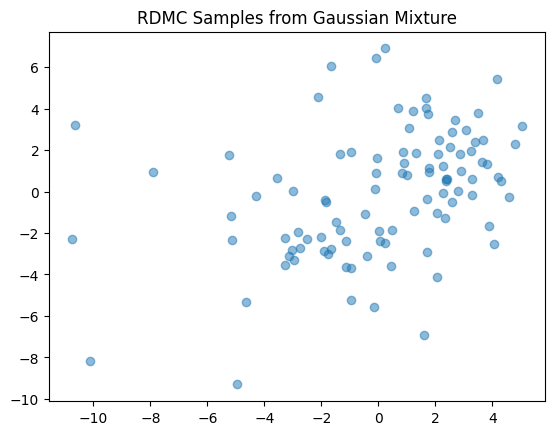

In [4]:
import torch
import matplotlib.pyplot as plt

# 1. 定义目标分布（高斯混合模型）
def target_log_prob(x):
    mean1 = torch.tensor([-2.0, -2.0], device=x.device)
    mean2 = torch.tensor([2.0, 2.0], device=x.device)
    cov = torch.eye(2, device=x.device) * 0.5
    inv_cov = torch.inverse(cov)
    
    diff1 = x - mean1
    log_prob1 = -0.5 * (diff1 @ inv_cov * diff1).sum(dim=-1)
    
    diff2 = x - mean2
    log_prob2 = -0.5 * (diff2 @ inv_cov * diff2).sum(dim=-1)
    
    max_log = torch.maximum(log_prob1, log_prob2)
    log_mix = torch.log(0.5 * torch.exp(log_prob1 - max_log) + 0.5 * torch.exp(log_prob2 - max_log)) + max_log
    return log_mix

def target_log_prob_and_grad(x):
    x.requires_grad_(True)
    log_prob = target_log_prob(x)
    grad = torch.autograd.grad(log_prob.sum(), x)[0]
    return log_prob.detach(), grad.detach()

# 2. 初始化样本
batch_size = 100
dim = 2
T = torch.tensor(1.0)
x_init = torch.randn(batch_size, dim) * torch.sqrt(1.0 - torch.exp(-2.0 * T))

# 3. 运行 RDMC
samples = rdmc_algorithm(
    x_init,
    target_log_prob,
    target_log_prob_and_grad,
    T=T,
    K=100,
    n_warm_start_steps=50,
    n_chains=10,
    n_mcmc_steps=10,
    n_mc_samples=128,
    verbose=True
)

# 4. 可视化
plt.scatter(samples[:, 0].cpu().numpy(), samples[:, 1].cpu().numpy(), alpha=0.5)
plt.title("RDMC Samples from Gaussian Mixture")
plt.show()

C:\Users\Mocking Jimmy\AppData\Local\Temp\ipykernel_17500\924878442.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  self.means = torch.tensor(means, device=device)



Running Chain 1


100%|██████████| 199/199 [01:19<00:00,  2.50it/s]



Running Chain 2


100%|██████████| 199/199 [01:20<00:00,  2.46it/s]



Running Chain 3


100%|██████████| 199/199 [01:25<00:00,  2.31it/s]


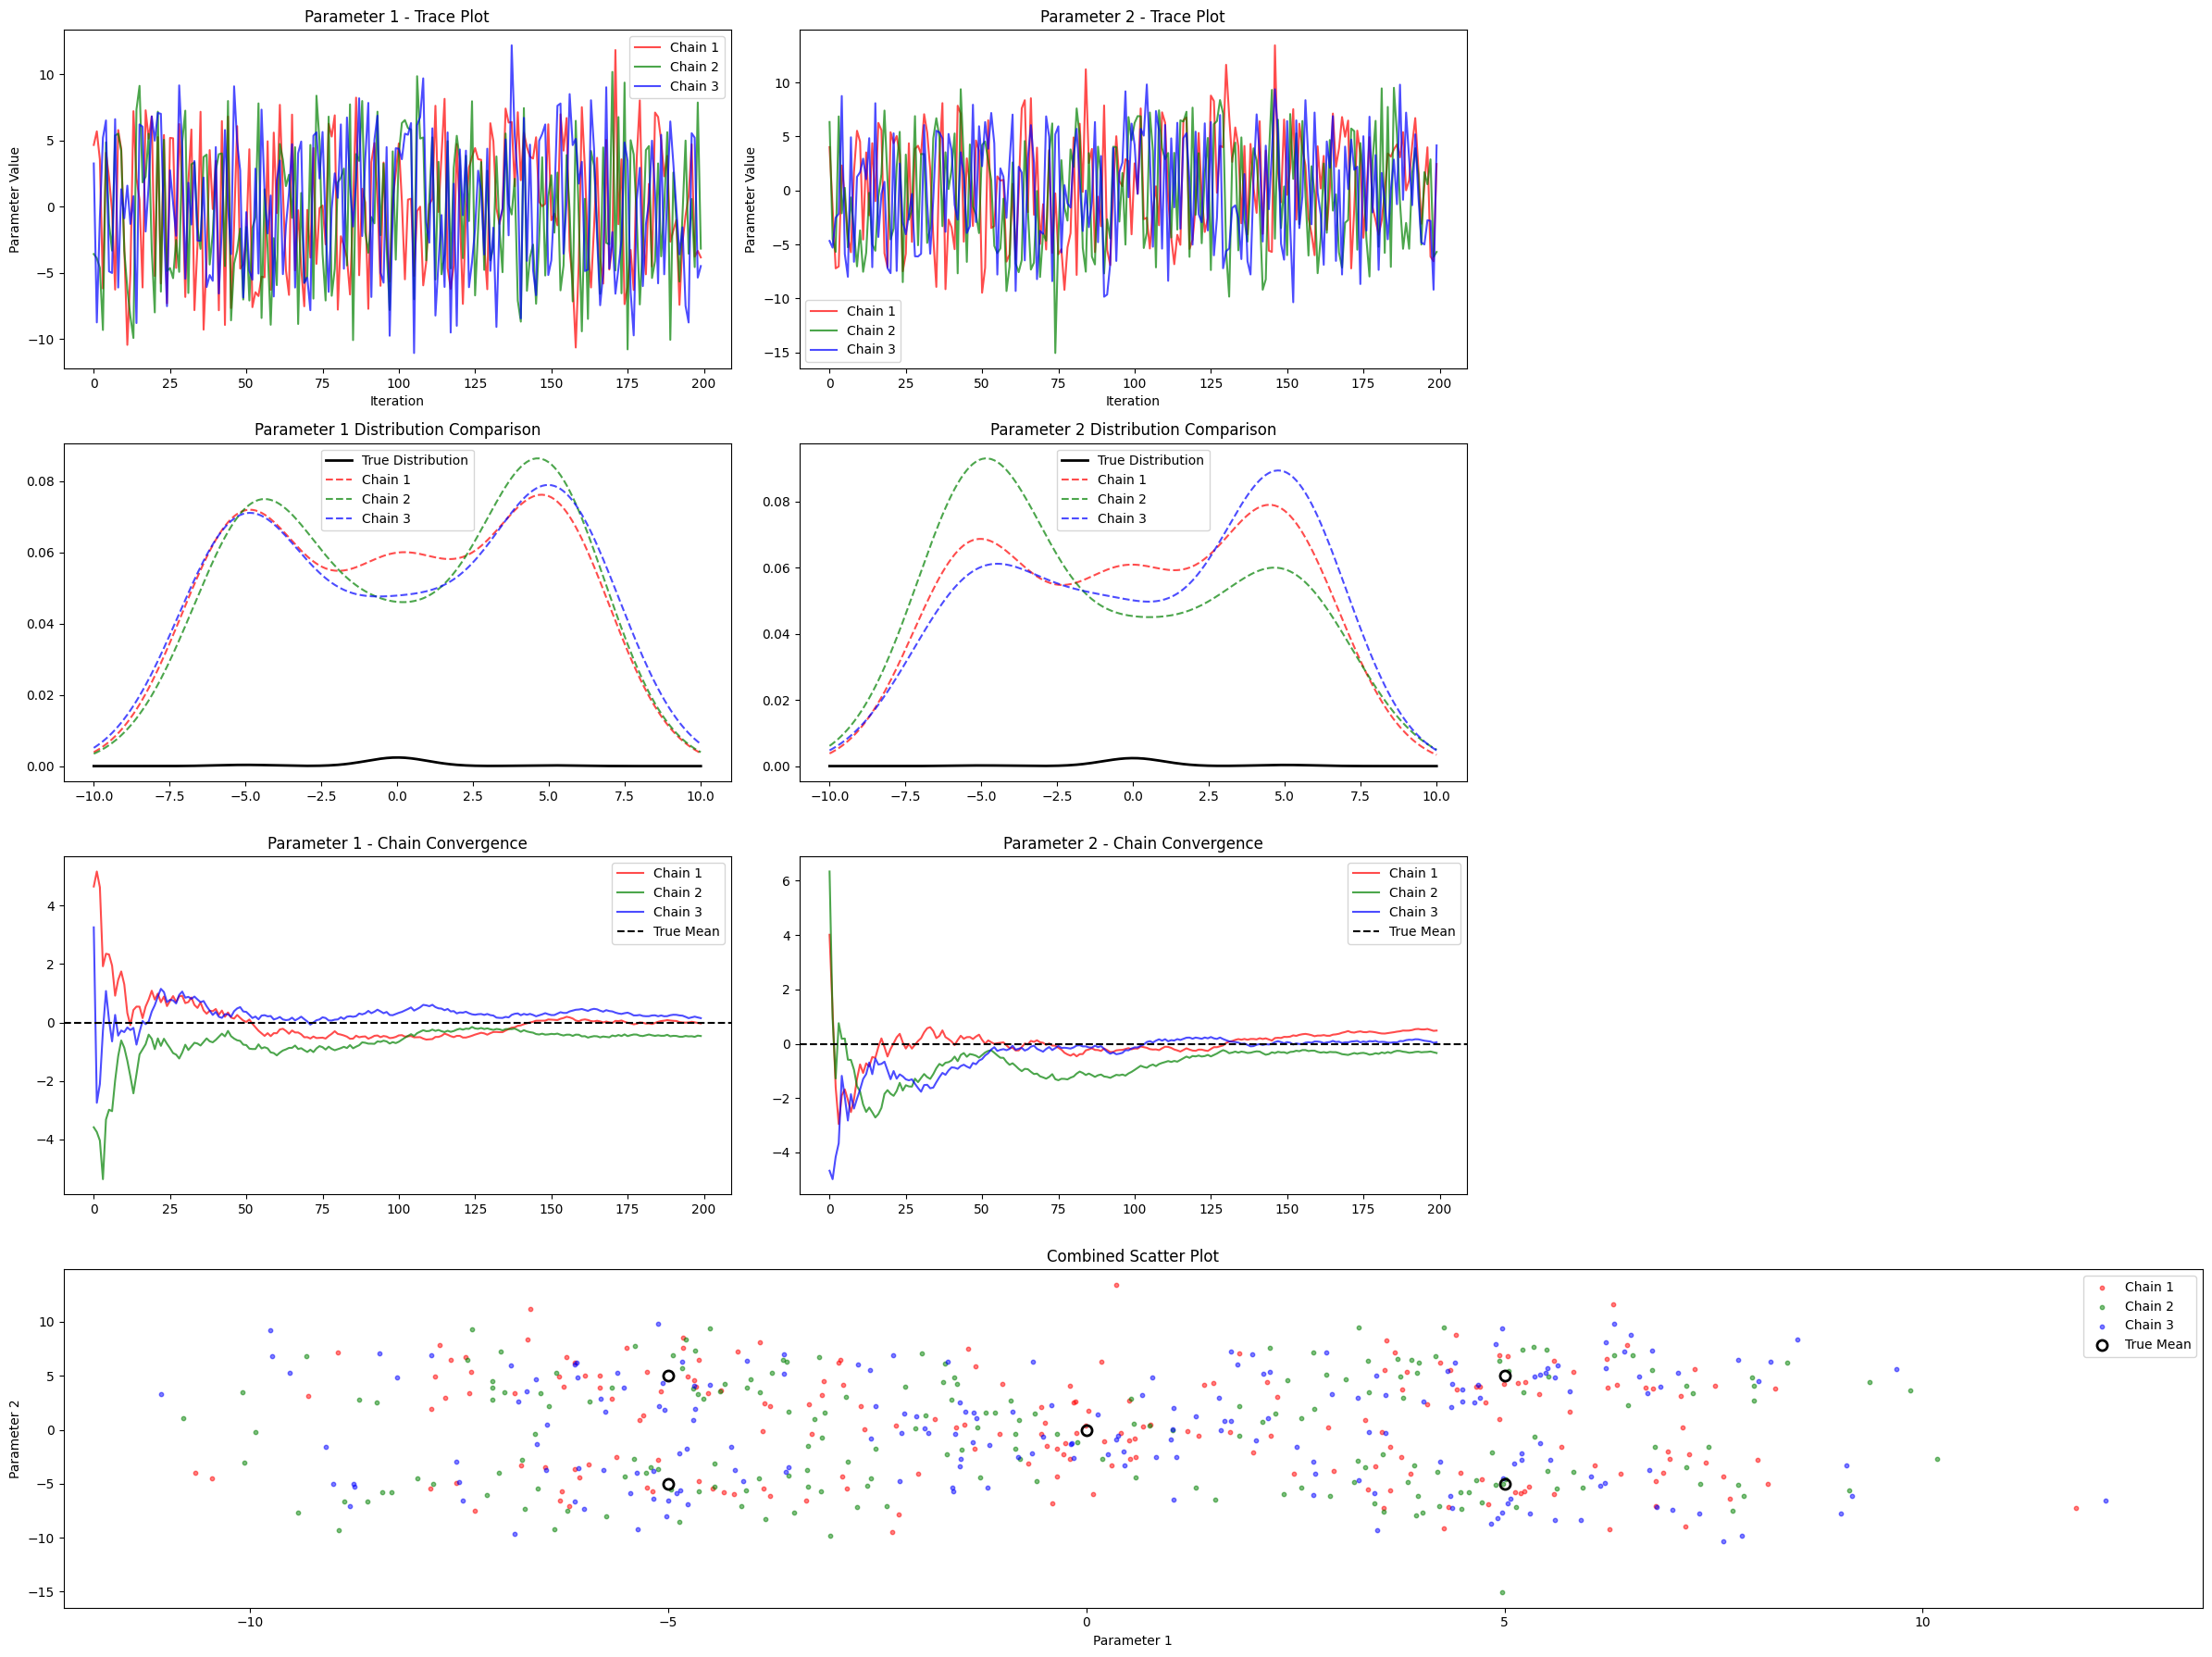

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde, norm
from tqdm import trange

# 定义多模态正态分布模型
class MultiModalNormalDistribution:
    def __init__(self, means, covariances, weights, device='cpu'):
        self.means = torch.tensor(means, device=device)
        self.covariances = torch.tensor(covariances, device=device)
        self.weights = torch.tensor(weights, device=device)
        self.n_modes = len(means)
        self.dimensions = means[0].shape[0]
        self.device = device
        
    def log_prob(self, x):
        log_prob = -torch.inf * torch.ones(x.shape[0], device=self.device)
        pi = torch.tensor(2 * torch.pi, device=self.device)  # 将常数转为张量
        
        for i in range(self.n_modes):
            diff = x - self.means[i]
            inv_cov = torch.linalg.inv(self.covariances[i])
            det_cov = torch.linalg.det(self.covariances[i])
            component_log_prob = torch.log(self.weights[i]) - 0.5 * torch.einsum('bi,ij,bj->b', diff, inv_cov, diff) \
                                - 0.5 * torch.log(det_cov) - 0.5 * self.dimensions * torch.log(pi)
            log_prob = torch.logaddexp(log_prob, component_log_prob)
        return log_prob

    def log_prob_and_grad(self, x):
        x.requires_grad_(True)
        log_prob = self.log_prob(x)
        grad = torch.autograd.grad(log_prob.sum(), x)[0]
        return log_prob.detach(), grad.detach()

# 可视化函数
def enhanced_visualization(samples_list, weights_list, means, covariances, weights, titles=None):
    if titles is None:
        titles = [f'Chain {i+1}' for i in range(len(samples_list))]
    
    n_chains = len(samples_list)
    colors = ['r', 'g', 'b']  # 不同链的颜色
    
    # 创建更大的画布和更复杂的网格布局
    plt.figure(figsize=(24, 18))
    gs = gridspec.GridSpec(4, 3, width_ratios=[1,1,1], height_ratios=[1,1,1,1])
    
    # 1. 参数1的迹线图
    ax_trace1 = plt.subplot(gs[0, 0])
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        ax_trace1.plot(samples[:,0], colors[chain_idx]+'-', alpha=0.7, label=titles[chain_idx])
    ax_trace1.legend()
    ax_trace1.set_title('Parameter 1 - Trace Plot')
    ax_trace1.set_xlabel('Iteration')
    ax_trace1.set_ylabel('Parameter Value')
    
    # 2. 参数2的迹线图
    ax_trace2 = plt.subplot(gs[0, 1])
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        ax_trace2.plot(samples[:,1], colors[chain_idx]+'-', alpha=0.7, label=titles[chain_idx])
    ax_trace2.legend()
    ax_trace2.set_title('Parameter 2 - Trace Plot')
    ax_trace2.set_xlabel('Iteration')
    ax_trace2.set_ylabel('Parameter Value')
    
    # 3. 参数1的分布对比
    ax_dist1 = plt.subplot(gs[1, 0])
    x = np.linspace(-10, 10, 200)
    true_pdf = np.zeros_like(x)
    for i in range(len(means)):
        mean = means[i][0]
        cov = covariances[i][0,0]
        true_pdf += weights[i] * norm.pdf(x, mean, np.sqrt(cov))
    ax_dist1.plot(x, true_pdf, 'k-', linewidth=2, label='True Distribution')
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        weights_chain = weights_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        if weights_chain.ndim > 1:
            weights_chain = weights_chain.flatten()
        
        # 检查并清理数据和权重
        valid_indices = np.isfinite(samples[:,0]) & np.isfinite(weights_chain) & (weights_chain > 0)
        if np.sum(valid_indices) > 0:
            kde = gaussian_kde(samples[valid_indices, 0], weights=weights_chain[valid_indices])
            ax_dist1.plot(x, kde(x), colors[chain_idx]+'--', alpha=0.7, label=titles[chain_idx])
        else:
            print(f"Warning: No valid data for chain {chain_idx} in parameter 1 distribution comparison.")
    ax_dist1.set_title('Parameter 1 Distribution Comparison')
    ax_dist1.legend()
    
    # 4. 参数2的分布对比
    ax_dist2 = plt.subplot(gs[1, 1])
    y = np.linspace(-10, 10, 200)
    true_pdf = np.zeros_like(y)
    for i in range(len(means)):
        mean = means[i][1]
        cov = covariances[i][1,1]
        true_pdf += weights[i] * norm.pdf(y, mean, np.sqrt(cov))
    ax_dist2.plot(y, true_pdf, 'k-', linewidth=2, label='True Distribution')
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        weights_chain = weights_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        if weights_chain.ndim > 1:
            weights_chain = weights_chain.flatten()
        
        # 检查并清理数据和权重
        valid_indices = np.isfinite(samples[:,1]) & np.isfinite(weights_chain) & (weights_chain > 0)
        if np.sum(valid_indices) > 0:
            kde = gaussian_kde(samples[valid_indices, 1], weights=weights_chain[valid_indices])
            ax_dist2.plot(y, kde(y), colors[chain_idx]+'--', alpha=0.7, label=titles[chain_idx])
        else:
            print(f"Warning: No valid data for chain {chain_idx} in parameter 2 distribution comparison.")
    ax_dist2.set_title('Parameter 2 Distribution Comparison')
    ax_dist2.legend()
    
    # 5. 参数1的链收敛
    ax_conv1 = plt.subplot(gs[2, 0])
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        running_mean = np.cumsum(samples[:,0]) / np.arange(1, len(samples)+1)
        ax_conv1.plot(running_mean, colors[chain_idx]+'-', alpha=0.7, label=titles[chain_idx])
    true_mean = sum(w*m[0] for w, m in zip(weights, means))
    ax_conv1.axhline(true_mean, color='k', linestyle='--', label='True Mean')
    ax_conv1.set_title('Parameter 1 - Chain Convergence')
    ax_conv1.legend()
    
    # 6. 参数2的链收敛
    ax_conv2 = plt.subplot(gs[2, 1])
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        running_mean = np.cumsum(samples[:,1]) / np.arange(1, len(samples)+1)
        ax_conv2.plot(running_mean, colors[chain_idx]+'-', alpha=0.7, label=titles[chain_idx])
    true_mean = sum(w*m[1] for w, m in zip(weights, means))
    ax_conv2.axhline(true_mean, color='k', linestyle='--', label='True Mean')
    ax_conv2.set_title('Parameter 2 - Chain Convergence')
    ax_conv2.legend()
    
    # 7. 散点图
    ax_scatter = plt.subplot(gs[3, :])  # 跨所有列
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        weights = weights_list[chain_idx].cpu().numpy()  # 确保移动到 CPU
        if weights.ndim > 1:
            weights = weights.flatten()
        valid_indices = np.isfinite(samples[:,0]) & np.isfinite(samples[:,1]) & np.isfinite(weights) & (weights > 0)
        if np.sum(valid_indices) > 0:
            ax_scatter.scatter(samples[valid_indices, 0], samples[valid_indices, 1], c=colors[chain_idx], 
                              alpha=0.5, s=10, label=titles[chain_idx])
        else:
            print(f"Warning: No valid data for chain {chain_idx} in scatter plot.")
    for mean in means:
        ax_scatter.plot(mean[0], mean[1], 'ko', markersize=8, markeredgewidth=2,
                       markerfacecolor='none', label='True Mean' if mean is means[0] else "")
    ax_scatter.set_xlabel('Parameter 1')
    ax_scatter.set_ylabel('Parameter 2')
    ax_scatter.set_title('Combined Scatter Plot')
    ax_scatter.legend()
    
    plt.tight_layout()
    plt.show()
def run_rdmc_with_visualization():
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 定义多模态分布参数
    dimensions = 2
    means = [np.array([0.0, 0.0]), np.array([5.0, 5.0]), 
             np.array([-5.0, 5.0]), np.array([5.0, -5.0]), 
             np.array([-5.0, -5.0])]
    covariances = [np.eye(dimensions) for _ in range(len(means))]
    weights = [1.0/len(means)] * len(means)
    
    # 创建概率模型
    target = MultiModalNormalDistribution(means, covariances, weights, device=device)
    
    # RDMC参数
    T = 1
    K = 200
    n_warm_start_steps = 100
    n_chains = 10
    n_mcmc_steps = 20
    n_mc_samples = 256
    batch_size = 200  # 粒子数
    
    # 运行3条不同起点的链
    all_samples = []
    all_weights = []
    
    for chain in range(3):  # 运行3条链
        print(f"\nRunning Chain {chain+1}")
        
        # 随机初始化点
        x_init = torch.randn((batch_size, dimensions), device=device) * np.sqrt(1.0 - np.exp(-2.0 * T))
        
        # 运行RDMC采样
        samples = rdmc_algorithm(
            x_init, 
            target.log_prob, 
            target.log_prob_and_grad, 
            T, 
            K, 
            n_warm_start_steps=n_warm_start_steps,
            n_chains=n_chains,
            n_mcmc_steps=n_mcmc_steps,
            n_mc_samples=n_mc_samples,
            verbose=True
        )
        
        # 计算权重 (这里简化处理，实际RDMC可能需要不同的权重计算方式)
        log_probs = target.log_prob(samples)
        weights = torch.exp(log_probs - torch.max(log_probs))
        weights = weights / torch.sum(weights)
        
        all_samples.append(samples)
        all_weights.append(weights)
    
    # 转换为numpy数组用于可视化
    means_np = [m.cpu().numpy() if torch.is_tensor(m) else m for m in means]
    covariances_np = [c.cpu().numpy() if torch.is_tensor(c) else c for c in covariances]
    weights_np = [w.cpu().numpy() if torch.is_tensor(w) else w for w in weights]
    
    # 增强可视化
    enhanced_visualization(
        all_samples, 
        all_weights, 
        means_np, 
        covariances_np, 
        weights_np,
        titles=['Chain 1', 'Chain 2', 'Chain 3']
    )

# 运行RDMC采样和可视化
run_rdmc_with_visualization()